<a href="https://colab.research.google.com/github/chminPark/ml-python/blob/master/%EC%8B%A4%EC%8A%B5_%EB%94%A5%EB%9F%AC%EB%8B%9D%ED%9A%8C%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pytorch로 개발하기 위한 Library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np

torch.__version__

'2.1.0+cu118'

In [ ]:
def show_predicted(x, y, preds, ax=None, title=""):
    if ax is None:
      ax=plt.subplots(figsize=(3,3))[1]
    ax.scatter(x,y, label='true')

    if preds is not None:
      ax.scatter(x, preds, label='pred', color='red')
    ax.set_title(title)
    ax.legend()


# 데이터를 대해 Train, Validation, Test용으로 나누는 실습을 한다
* 학습부/평가부를 나누어야 한다

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99785E3F5E48AEC50A" height="300px" width="500px">


참고

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
https://blog.naver.com/PostView.naver?blogId=siniphia&logNo=221396370872

In [ ]:
from sklearn.model_selection import train_test_split

def get_train_testset(X,y, tensor=False, show=True):

  ############## 실습 : train_test_split을 이용하여 데이터를 나눈다.
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  ####################################

  if show:
    fig, ax = plt.subplots(1,2, figsize=(5,2))
    ax[0].scatter(X_train, y_train, s=100)
    ax[1].scatter(X_test, y_test, s=100)

  if tensor:
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    #X_train = x_train.view(X_train.size(0), -1)
    #y_train = y_train.view(y_train.size(0), -1)

    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    #X_test = X_test.view(X_test.size(0), -1)
    #y_test = y_test.view(y_test.size(0), -1)

  return X_train, X_test, y_train, y_test

# 당노병 데이터를 이용하여 본격적인 실습을 해 봅시다.
* LSTM로 문제를 해결해 본다

In [ ]:
#importing the inbuilt dataset in sklearn package for performing regression analysis.
from sklearn import datasets
diabetes = datasets.load_diabetes()
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [ ]:
print(f"feature names: {diabetes.feature_names }")
print(f"data shape: {diabetes.data.shape}")

feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
data shape: (442, 10)


In [ ]:
import pandas as pd

df_data = pd.DataFrame(diabetes.data,columns=diabetes.feature_names)
df_data['target'] = diabetes.target # add target
df_data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


## 데이터 확인
 * 데이터에 NaN이 있는지 확인
 * 인자간 상관관계 확인: 인자산 선형 관계성은 Correlation 을 이용하여 해결함

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ee1e03b44aabd2904cca430279faad515c617891" height="80px" width="400px">


<img src="https://www.simplilearn.com/ice9/free_resources_article_thumb/Pearson_Correlation_1.jpg" height="300px" width="500px">


참고

https://hyen4110.tistory.com/38
https://wikidocs.net/157461

In [ ]:
# 각 인자의 특징을 확인하는 것은 describe() 함수를 활용하면 됨
df_data.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


In [ ]:
# 각 인자에 NaN이  있는지 확인
print(df_data.isna().sum())
print(f"NaN Exist = {df_data.isna().any().any()}")

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64
NaN Exist = False


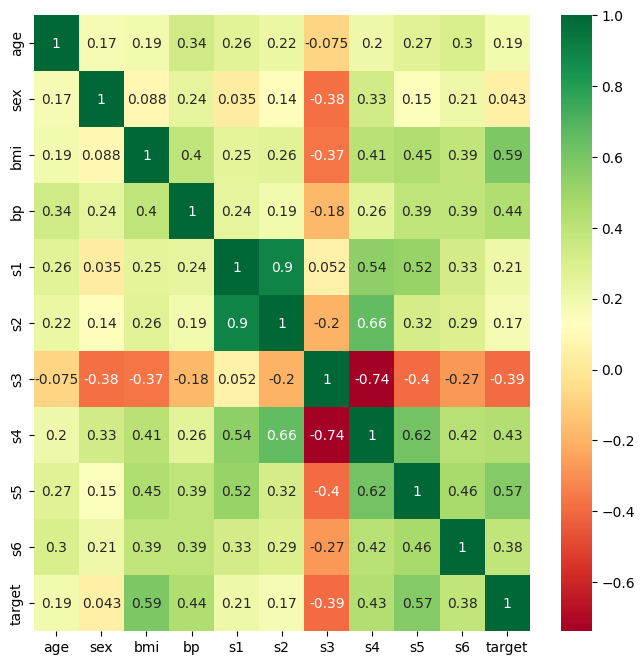

In [ ]:
#### 실습: 어떤 지수가 서로 관련이 있는지 확인해 보세요
##########################################################
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(8,8))
sns.heatmap(df_data.corr(),cmap= 'RdYlGn',annot=True)
plt.show()


In [ ]:

#independent variables / explanatory variables
x = df_data.drop(labels='target', axis=1)  #axis=1 means we drop data by column.

#dependent variable / response / target variable.
y = df_data['target']


# LSTM 구현

* LSTM Arcitecture

<img src="https://api.wandb.ai/files/sauravmaheshkar/images/projects/445540/3b5df3df.png
" height="200px" width="300px">


* L = Sequence Length
* N = Batch Size
* Hin=input_size (=num of features)

* tensor shape (L,Hin) for unbatched input
* tensor shape (N, L, Hin) when batch_first=True
* tensor shape (L, N, Hin) when batch_forst=False

* num_layers는 LSTM의 개수를 의미함

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FVJ2Yi%2FbtrE4VSN4tw%2FwO0TxP67kQqpOJiN0vP3N0%2Fimg.png
" height="150px" width="400px">

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbEv7iK%2FbtrE5tnWMD7%2FBGvkQClKqRp3shsOhUJJ20%2Fimg.png
" height="150px" width="400px">




https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

https://hongl.tistory.com/247

https://ok-lab.tistory.com/209

In [ ]:
from sklearn import datasets
diabetes = datasets.load_diabetes()
df_data = pd.DataFrame(diabetes.data,columns=diabetes.feature_names)
df_data['target'] = diabetes.target # add target
x_train, x_test, y_train, y_test = get_train_testset(x.values,y.values, tensor=True, show=False)
x_train, x_val, y_train, y_val = get_train_testset(x_train,y_train,  show=False)

y_train = y_train.view(-1,1)
y_val = y_val.view(-1,1)
y_test = y_test.view(-1,1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print("==" * 10)


# 입력 길이는 1
x_train = x_train.unsqueeze(dim=1)
x_val = x_val.unsqueeze(dim=1)
x_test = x_test.unsqueeze(dim=1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([282, 10])
torch.Size([89, 10])
torch.Size([282, 1])
torch.Size([89, 1])
torch.Size([282, 1, 10])
torch.Size([89, 1, 10])
torch.Size([282, 1])
torch.Size([89, 1])


## LSTM 객체를 생성한다.

In [ ]:
# Pytorch로 개발하기 위한 Library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm

    self.fc =  nn.Sequential(nn.Linear(hidden_size, int(hidden_size/2)),
                             nn.ReLU(),
                             nn.Linear(int(hidden_size/2), num_classes)
    )



  def forward(self,x):

    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

    # Propagate input through LSTM
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state

    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next

    batch_size = x.shape[0]

    out = self.fc(hn) # Final Output


    return out

Initial Cost: 173.0041961669922
Epoch    1/100000, Cost_train: 173.003891, Cost_val: 159.058456
Epoch 10001/100000, Cost_train: 161.568359, Cost_val: 147.726929
Epoch 20001/100000, Cost_train: 77.121849, Cost_val: 74.425980
Epoch 30001/100000, Cost_train: 76.083237, Cost_val: 73.656952
Epoch 40001/100000, Cost_train: 72.505280, Cost_val: 70.779526
Epoch 50001/100000, Cost_train: 59.377083, Cost_val: 63.118881
Epoch 60001/100000, Cost_train: 56.213070, Cost_val: 58.145924
Epoch 70001/100000, Cost_train: 55.653103, Cost_val: 55.735077
Epoch 80001/100000, Cost_train: 55.527050, Cost_val: 55.194431
Epoch 90001/100000, Cost_train: 55.439308, Cost_val: 55.075153
Train accuracy(RMSE) :  55.352195739746094
Test accuracy(RMSE) : 47.488094329833984


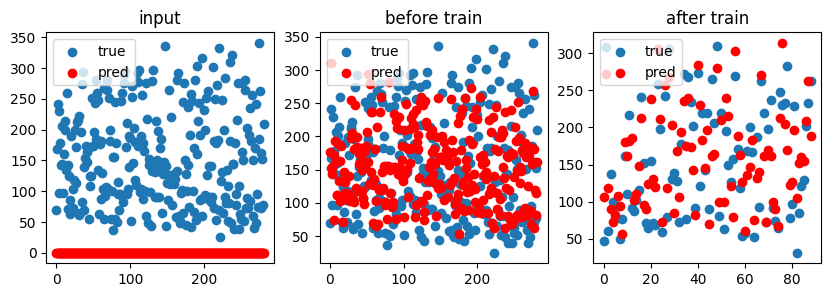

In [ ]:
import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

seed = 27
torch.manual_seed(seed) # cpu 연산 무작위 고정
torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
torch.cuda.manual_seed_all(seed) # 멀티 gpu 연산 무작위 고정
np.random.seed(seed) # numpy 관련 연산 무작위 고정


#####################
### 실습 : LSTM을 이용하여 실습을 수행한다.
### num_layer를 2로 하면 어떻게 될까요?
# num_classes=1, input_size=10, hidden_size=50
model = LSTM(num_classes=1, input_size=10, hidden_size=50, num_layers=1)
##################


preds = model(x_train)

fig, ax = plt.subplots(1,3, figsize=(10,3))

show_predicted(np.arange(0, x_train.shape[0]), y_train, preds.detach().numpy(), ax[0], title="input")

cost =  torch.sqrt(nn.MSELoss()(preds,  y_train))

print(f"Initial Cost: {cost}")

# Weight와 Bias를 cost를 줄이는 방향으로 업데이트 ~ Optimization(최적화)
optimizer = torch.optim.SGD( model.parameters(), lr=0.0003)

nb_epochs = 100000 # 원하는만큼 경사 하강법을 반복
for epoch in range(nb_epochs + 1):

    preds = model(x_train)
    # cost 계산
    cost = torch.sqrt(nn.MSELoss()(preds, y_train))

    optimizer.zero_grad() # 초기화
    cost.backward() # gradient계산
    optimizer.step() # 계산된 gradient 값을 이용하여 W,b 업데이트


    preds_val = model(x_val)
    # cost 계산
    cost_val = torch.sqrt(nn.MSELoss()(preds_val, y_val))


    # 로그 출력
    if epoch % (nb_epochs/10) == 1:
      print(f'Epoch {epoch:4d}/{nb_epochs}, Cost_train: {cost.item():.6f}, Cost_val: {cost_val.item():.6f}')

preds = model(x_train)
show_predicted(range(x_train.shape[0]), y_train, preds.detach().numpy(),ax[1], title="before train")
print(f"Train accuracy(RMSE) :  {torch.sqrt(nn.MSELoss()(preds,  y_train))}")

preds_test = model(x_test)
print(f"Test accuracy(RMSE) : { torch.sqrt(nn.MSELoss()(preds_test,  y_test))}")
show_predicted(range(x_test.shape[0]), y_test, preds_test.detach().numpy(),ax[2], title="after train")

In [ ]:
############## 실습

class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm

    self.fc =  nn.Sequential(nn.Linear(hidden_size, int(hidden_size/2)),
                             nn.ReLU(),
                             nn.Linear(int(hidden_size/2), num_classes)
    )



  def forward(self,x):

    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

    # Propagate input through LSTM
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state

    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next

    batch_size = x.shape[0]

    ##### [실습] 어떻게 변경해서 num_layer=2 일때 동작할까요?
    #####  hn 은 num_layer *  입력개수의 크기를 가집니다.
    ######### 맨 마지막 layer의 출력만 가지고 와야 합니다.
    out = self.fc(hn[-batch_size:,:]) #Final Output

    return out

Initial Cost: 172.92294311523438
Train accuracy(RMSE) :  54.845272064208984
Test accuracy(RMSE) : 47.69260787963867


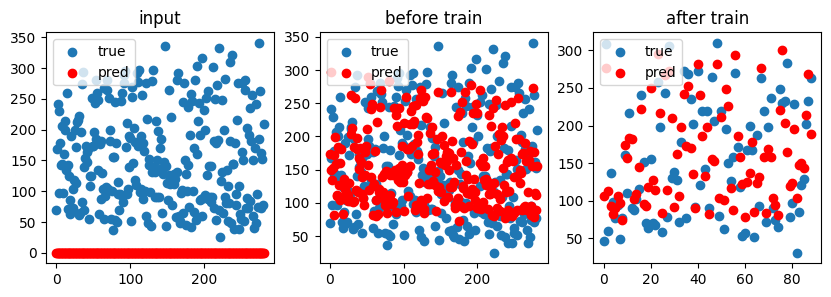

In [ ]:
############ 실습 : num_layer=2 로 변경해 봅시다

import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

seed = 27
torch.manual_seed(seed) # cpu 연산 무작위 고정
torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
torch.cuda.manual_seed_all(seed) # 멀티 gpu 연산 무작위 고정
np.random.seed(seed) # numpy 관련 연산 무작위 고정


from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler



model = LSTM(num_classes=1, input_size=10, hidden_size=50, num_layers=2)
preds = model(x_train)

fig, ax = plt.subplots(1,3, figsize=(10,3))

show_predicted(np.arange(0, x_train.shape[0]), y_train, preds.detach().numpy(), ax[0], title="input")

cost =  torch.sqrt(nn.MSELoss()(preds,  y_train))

print(f"Initial Cost: {cost}")


optimizer = torch.optim.SGD( model.parameters(), lr=0.0003)

nb_epochs = 100000 # 원하는만큼 경사 하강법을 반복
for epoch in range(nb_epochs + 1):

    preds = model(x_train)
    # cost 계산
    cost = torch.sqrt(nn.MSELoss()(preds, y_train))

    optimizer.zero_grad() # 초기화
    cost.backward() # gradient계산
    optimizer.step() # 계산된 gradient 값을 이용하여 W,b 업데이트


preds = model(x_train)
show_predicted(range(x_train.shape[0]), y_train, preds.detach().numpy(),ax[1], title="before train")
print(f"Train accuracy(RMSE) :  {torch.sqrt(nn.MSELoss()(preds,  y_train))}")

preds_test = model(x_test)
print(f"Test accuracy(RMSE) : { torch.sqrt(nn.MSELoss()(preds_test,  y_test))}")
show_predicted(range(x_test.shape[0]), y_test, preds_test.detach().numpy(),ax[2], title="after train")

Initial Cost: 172.92294311523438
Epoch    1/100000, Cost_train: 172.922638, Cost_val: 158.977768
Epoch 10001/100000, Cost_train: 160.889847, Cost_val: 147.054901
Epoch 20001/100000, Cost_train: 77.615631, Cost_val: 74.809319
Epoch 30001/100000, Cost_train: 77.555450, Cost_val: 74.768570
Epoch 40001/100000, Cost_train: 77.445930, Cost_val: 74.691490
Epoch 50001/100000, Cost_train: 77.171463, Cost_val: 74.492813
Epoch 60001/100000, Cost_train: 75.932961, Cost_val: 73.559395
Epoch 70001/100000, Cost_train: 57.398987, Cost_val: 62.231152
Epoch 80001/100000, Cost_train: 55.162518, Cost_val: 56.631123
Epoch 90001/100000, Cost_train: 55.007484, Cost_val: 56.588219
Train accuracy(RMSE) :  54.845272064208984
Test accuracy(RMSE) : 47.69260787963867


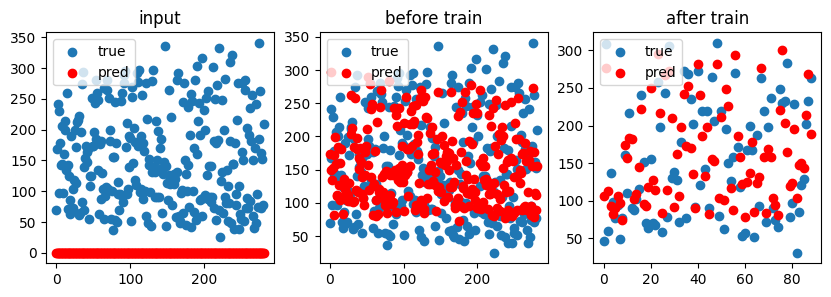

In [ ]:
############ 실습 : num_layer=2 로 변경해 봅시다

import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

seed = 27
torch.manual_seed(seed) # cpu 연산 무작위 고정
torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
torch.cuda.manual_seed_all(seed) # 멀티 gpu 연산 무작위 고정
np.random.seed(seed) # numpy 관련 연산 무작위 고정


from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


# 학습해야 하는 모델 선언. hidden layer 크기가 인경우를 구현한다
model = LSTM(num_classes=1, input_size=10, hidden_size=50, num_layers=2)
preds = model(x_train)

fig, ax = plt.subplots(1,3, figsize=(10,3))

show_predicted(np.arange(0, x_train.shape[0]), y_train, preds.detach().numpy(), ax[0], title="input")

cost =  torch.sqrt(nn.MSELoss()(preds,  y_train))

print(f"Initial Cost: {cost}")

# Weight와 Bias를 cost를 줄이는 방향으로 업데이트 ~ Optimization(최적화)
optimizer = torch.optim.SGD( model.parameters(), lr=0.0003)

nb_epochs = 100000 # 원하는만큼 경사 하강법을 반복
for epoch in range(nb_epochs + 1):

    preds = model(x_train)
    # cost 계산
    cost = torch.sqrt(nn.MSELoss()(preds, y_train))

    optimizer.zero_grad() # 초기화
    cost.backward() # gradient계산
    optimizer.step() # 계산된 gradient 값을 이용하여 W,b 업데이트


    preds_val = model(x_val)
    # cost 계산
    cost_val = torch.sqrt(nn.MSELoss()(preds_val, y_val))


    # 로그 출력
    if epoch % (nb_epochs/10) == 1:
      print(f'Epoch {epoch:4d}/{nb_epochs}, Cost_train: {cost.item():.6f}, Cost_val: {cost_val.item():.6f}')

preds = model(x_train)
show_predicted(range(x_train.shape[0]), y_train, preds.detach().numpy(),ax[1], title="before train")
print(f"Train accuracy(RMSE) :  {torch.sqrt(nn.MSELoss()(preds,  y_train))}")

preds_test = model(x_test)
print(f"Test accuracy(RMSE) : { torch.sqrt(nn.MSELoss()(preds_test,  y_test))}")
show_predicted(range(x_test.shape[0]), y_test, preds_test.detach().numpy(),ax[2], title="after train")

# [주가예측] Sequence길이가 N개인 경우는?
* Pandas DataFrame 의 Rolling을 이용하면 MovingAverage를 계산 가능합니다.


<img src="https://datagy.io/wp-content/uploads/2020/07/How-to-Calculate-a-Rolling-Average-in-Pandas-1024x576.png
" height="350px" width="500px">


<img src="https://i0.wp.com/www.datasciencelearner.com/wp-content/uploads/2021/07/Simple-Dataframe-for-Implementing-Rolling-mean.jpg?ssl=1
" height="200px" width="400px">


<img src="https://www.datasciencelearner.com/ezoimgfmt/i0.wp.com/www.datasciencelearner.com/wp-content/uploads/2021/07/Rolling-mean-for-the-simple-dataframe.jpg?resize=450%2C183&ssl=1&ezimgfmt=ng:webp/ngcb11
" height="200px" width="400px">




[참고]

https://wikidocs.net/152788

https://www.datasciencelearner.com/pandas-rolling-mean-implementation-python-steps/

In [ ]:
!pip install finance-datareader
!pip install requests_cache

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
import FinanceDataReader as fdr
import pandas_datareader as pdr
import requests_cache
import matplotlib.pyplot as plt
import pandas as pd

start_date = '20100101'
end_date = '20221231'

df = fdr.DataReader('005930', start_date, end_date)   # 삼성전자: 005930


In [ ]:
################ 실습: 5일, 20일, 60일 이동평균선을 구한다
df['ma5'] = df['Close'].rolling(window=5).mean()
df['ma20'] = df['Close'].rolling(window=20).mean()
df['ma60'] = df['Close'].rolling(window=60).mean()
##################################################

# 다음날 종가를 예측
df['target'] = df['Close'].shift(-1)

df = df.dropna()

In [ ]:
df.isna().any()

Open      False
High      False
Low       False
Close     False
Volume    False
Change    False
ma5       False
ma20      False
ma60      False
target    False
dtype: bool

In [ ]:
df

,Open,High,Low,Close,Volume,Change,ma5,ma20,ma60,target
Date,,,,,,,,,,
2010-03-30,16540,16580,16240,16280,240934,-0.004890,16360.0,15851.0,15831.333333,16360.0
2010-03-31,16280,16680,16260,16360,434300,0.004914,16356.0,15898.0,15834.333333,16900.0
2010-04-01,16520,16900,16480,16900,561659,0.033007,16460.0,15982.0,15842.000000,17140.0
2010-04-02,16920,17200,16820,17140,419069,0.014201,16608.0,16064.0,15847.333333,17400.0
2010-04-05,17220,17400,17140,17400,304516,0.015169,16816.0,16148.0,15866.333333,17380.0
...,...,...,...,...,...,...,...,...,...,...
2022-12-22,58100,59100,58100,59100,10720630,0.018966,58940.0,59930.0,58913.333333,58100.0
2022-12-23,58200,58400,57700,58100,9829407,-0.016920,58660.0,59785.0,59000.000000,57900.0
2022-12-26,58000,58100,57700,57900,6756411,-0.003442,58340.0,59675.0,59088.333333,58100.0


## 입력의 Scaling 이 다를 때 전처리

* MinMaxScaling()

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbeIaIr%2FbtqIM7PCgJ3%2F2dnDTIc3XQK5s7zwwLNYZ0%2Fimg.png" height="80px" width="150px">

* Standard Scaling()

<img src="https://velog.velcdn.com/images%2Fjiselectric%2Fpost%2F8862ef9a-13a2-4402-8c80-1929d7c37083%2F0_PXGPVYIxyI_IEHP7.png" height="80px" width="150px">


참고

아래 블로그에 잘 정리되어 있네요

https://m.blog.naver.com/wideeyed/221614354947



In [ ]:
# Normilization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

data = df[['Close', 'Open', 'High', 'Low', 'ma5', 'ma20', 'ma60']]
target = df[['target']]

In [ ]:
data.describe()

,Close,Open,High,Low,ma5,ma20,ma60
count,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000,3148.000000
mean,39504.132783,39465.693774,39841.046061,39078.967916,39478.032402,39375.382783,39091.696739
std,18881.142087,18936.161527,19092.976848,18773.332417,18874.405631,18855.088914,18792.930283
min,13600.000000,0.000000,0.000000,0.000000,14044.000000,14540.000000,15311.333333
25%,25320.000000,25335.000000,25540.000000,25100.000000,25359.000000,25407.250000,24970.000000
50%,30930.000000,30960.000000,31270.000000,30630.000000,30846.000000,30436.500000,30073.166667
75%,51400.000000,51400.000000,52000.000000,50805.000000,51370.000000,51244.500000,50631.458333
max,91000.000000,90300.000000,96800.000000,89500.000000,89960.000000,86710.000000,84005.000000


In [ ]:
# Normilization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

data = df[['Close', 'Open', 'High', 'Low', 'ma5', 'ma20', 'ma60']]
target = df[['target']]

print(f"data shape: {data.shape}")
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_target = StandardScaler()
x = scaler.fit_transform(data)
y = scaler_target.fit_transform(target)
print(scaler.n_samples_seen_, scaler.feature_range)
print(x.shape, y.shape)
print(x[0,0:10])
print(y[0:5])

data shape: (3148, 7)
3148 (0, 1)
(3148, 7) (3148, 1)
[0.03462532 0.18316722 0.17128099 0.18145251 0.0305074  0.01816544
 0.00756984]
[[-1.22679042]
 [-1.19818221]
 [-1.18546745]
 [-1.17169312]
 [-1.17275269]]


In [ ]:
############ 실습 : MinMaxScaler 를 구현해 봅시다.
normalized_df=(data-data.min())/(data.max()-data.min())
###################

print(normalized_df.values[0, 0:10])


############ 실습 : StandardScaler 를 구현해 봅시다.
normalized_target=(target-target.mean())/target.std()
###################

print(normalized_target.values[0:5])


[0.03462532 0.18316722 0.17128099 0.18145251 0.0305074  0.01816544
 0.00756984]
[[-1.22659555]
 [-1.19799188]
 [-1.18527914]
 [-1.17150701]
 [-1.1725664 ]]


In [ ]:
##### 딥러닝에 넣을때에는 float 이여야 합니다.
test_idx = int(len(x) * 0.8)

x_train, y_train = x[:test_idx], y[:test_idx]
x_test, y_test = x[test_idx:], y[test_idx:]

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

x_train = torch.reshape(x_train,   (x_train.shape[0], 1, x_train.shape[1]))
x_test = torch.reshape(x_test,  (x_test.shape[0], 1, x_test.shape[1]))
y_train = y_train.view(-1,1)
y_test = y_test.view(-1,1)

x_train.shape, y_train.shape

(torch.Size([2518, 1, 7]), torch.Size([2518, 1]))

Initial Cost: 0.9081196188926697
Epoch    1/100000, Cost: 0.907917
Epoch 10001/100000, Cost: 0.634267
Epoch 20001/100000, Cost: 0.630872
Epoch 30001/100000, Cost: 0.625155
Epoch 40001/100000, Cost: 0.614318
Epoch 50001/100000, Cost: 0.589678
Epoch 60001/100000, Cost: 0.525445
Epoch 70001/100000, Cost: 0.318730
Epoch 80001/100000, Cost: 0.062546
Epoch 90001/100000, Cost: 0.059812
Train accuracy(RMSE) :  0.05875873938202858
Test accuracy(RMSE) : 0.27913084626197815


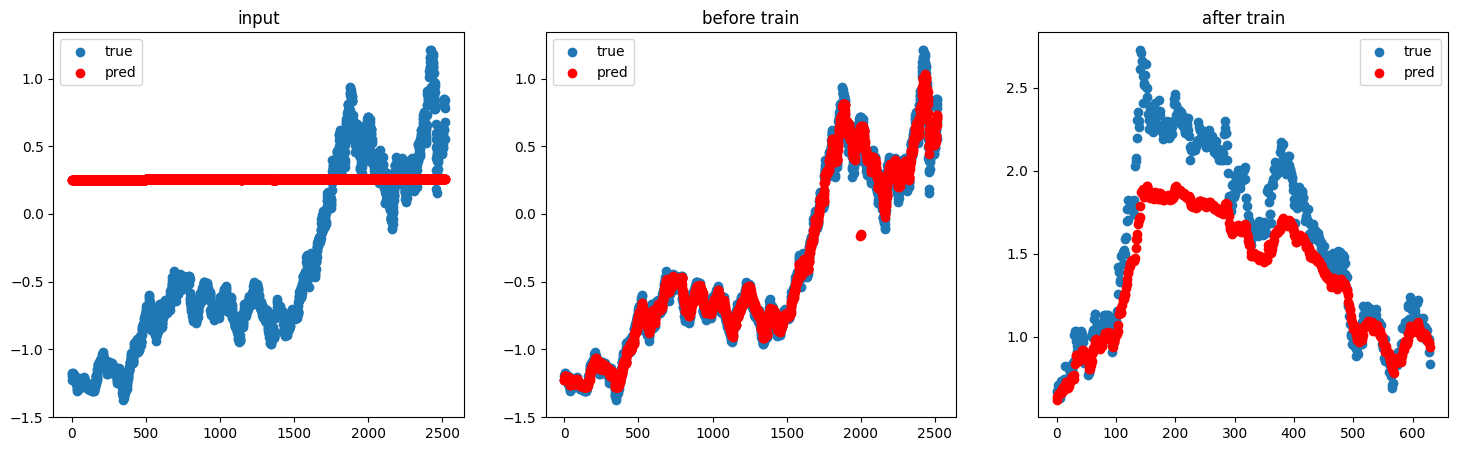

In [ ]:
import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

seed = 27
torch.manual_seed(seed) # cpu 연산 무작위 고정
torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
torch.cuda.manual_seed_all(seed) # 멀티 gpu 연산 무작위 고정
np.random.seed(seed) # numpy 관련 연산 무작위 고정


# 학습해야 하는 모델 선언. hidden layer 크기가 인경우를 구현한다
model = LSTM(num_classes=1, input_size=7, hidden_size=25, num_layers=1)
preds = model(x_train)

fig, ax = plt.subplots(1,3, figsize=(18,5))

show_predicted(np.arange(0, x_train.shape[0]), y_train, preds.detach().numpy(), ax[0], title="input")

cost =  torch.sqrt(nn.MSELoss()(preds,  y_train))

print(f"Initial Cost: {cost}")

# Weight와 Bias를 cost를 줄이는 방향으로 업데이트 ~ Optimization(최적화)
optimizer = torch.optim.SGD( model.parameters(), lr=0.0003)

nb_epochs = 100000 # 원하는만큼 경사 하강법을 반복
for epoch in range(nb_epochs + 1):

    preds = model(x_train)
    # cost 계산
    cost = torch.sqrt(nn.MSELoss()(preds, y_train))

    optimizer.zero_grad() # 초기화
    cost.backward() # gradient계산
    optimizer.step() # 계산된 gradient 값을 이용하여 W,b 업데이트


    # 로그 출력
    if epoch % (nb_epochs/10) == 1:
      print(f'Epoch {epoch:4d}/{nb_epochs}, Cost: {cost.item():.6f}')

preds = model(x_train)
show_predicted(range(x_train.shape[0]), y_train, preds.detach().numpy(),ax[1], title="before train")
print(f"Train accuracy(RMSE) :  {torch.sqrt(nn.MSELoss()(preds,  y_train))}")

preds_test = model(x_test)
print(f"Test accuracy(RMSE) : { torch.sqrt(nn.MSELoss()(preds_test,  y_test))}")
show_predicted(range(x_test.shape[0]), y_test, preds_test.detach().numpy(),ax[2], title="after train")

## 최종 결과에 대해서 Inverse Transform 하고 결과를 출력해 봅니다

In [ ]:
x_test.shape, y_test.shape

(torch.Size([630, 1, 7]), torch.Size([630, 1]))

Test accuracy(RMSE) : 0.27913084626197815


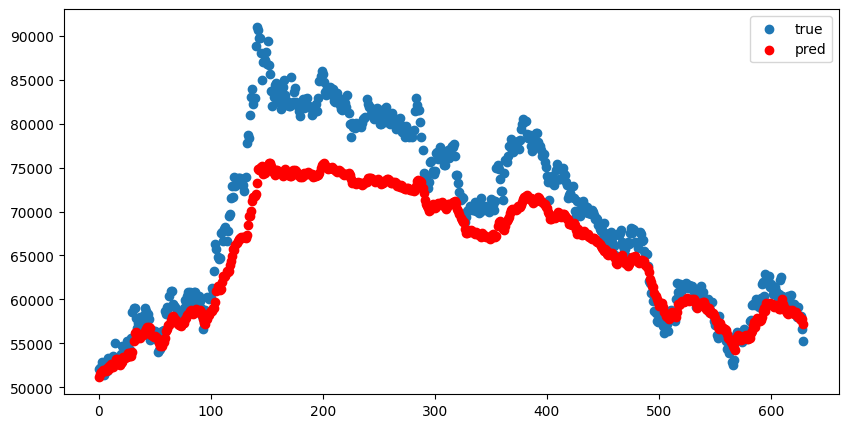

In [ ]:
preds_test = model(x_test)
print(f"Test accuracy(RMSE) : { torch.sqrt(nn.MSELoss()(preds_test,  y_test))}")

#### 실습 : Sequence 길이 부분을 제거한다
x_test_s = x_test.squeeze(1)

##### 실습 : Inverse Transform을 수행한다.
x_test_inv = scaler.inverse_transform(x_test_s)
y_test_inv = scaler_target.inverse_transform(y_test)
preds_test_inv = scaler_target.inverse_transform(preds_test.detach().numpy())

_, ax = plt.subplots(figsize=(10,5))
ax.scatter(range(x_test_inv.shape[0]),y_test_inv, label='true')
ax.scatter(range(x_test_inv.shape[0]), preds_test_inv, label='pred', color='red')
ax.legend()
